Quality metric based on the paper *Urban Sensing Based on Human Mobility* [link](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/06/urban-sensing-Ubicomp2016_Zheng.pdf)

In [2]:
import pandas as pd
import geopandas as gpd

import math

from tqdm import tqdm_notebook

import os

import matplotlib.pyplot as plt
%matplotlib inline

data_path = '/home/fterroso/data/'

/home/fterroso/python/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
import datetime
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d') #datetime.datetime.now()
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

from datetime import date, timedelta

delta = e_date - i_date       # as timedelta

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

In [4]:
def calculate_metric_for_od_fn(od, Qa_level):
    od['p'] = od['total'] /Qa_level
    od['log2_p'] = od['p'].apply(lambda x: math.log(x,2) if x > 0 else 0)
    od['p_log2_p'] = od['p'] * od['log2_p']
    sum_p_log2_p = od['p_log2_p'].sum()
    return 0-sum_p_log2_p

In [5]:
def calculate_hierarchical_entropy_fn(source, level, Qa_level):
    values = []
    for date in tqdm_notebook(target_days):
        if level == 'MA':
            od_date= pd.read_csv(os.path.join('data', 'OD', 'date_{}_OD_{}.csv'.format(source, date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        else:  #province level
            od_date= pd.read_csv(os.path.join('data', 'OD', 'date_{}_OD_{}_prov.csv'.format(source, date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        od_date = od_date.drop('total') 
        values.append((date, calculate_metric_for_od_fn(od_date, Qa_level)))
    coverage_df = pd.DataFrame.from_records(values, columns='date metric_value_{}_{}'.format(source,level).split())
    coverage_df= coverage_df.set_index('date')
    
    E_A_k= coverage_df['metric_value_{}_{}'.format(source,level)].sum()
    
    return E_A_k, coverage_df

In [6]:
def calculate_weight_factor_fn(global_od):
    I_k= global_od.shape[0]
    J_k= global_od.shape[0]
    T_k= len(target_days)
    
    I_1= 3215 # number of mobility areas
    J_1= 3215
    T_1= len(target_days)
    
    w_k = math.log(I_1*J_1*T_1,2)/math.log(I_k*J_k*T_k,2)
    
    return w_k

In [7]:
import numpy as np
def calculate_metric(source):
    k_max = 2
        
    global_od = pd.read_csv(os.path.join('data', 'OD', 'global_{}_OD.csv'.format(source)), index_col=0)
    
    w={}
    E_A_level = {}
    Q_A_level = {}
    levels = 'MA PROV'.split()
    
    coverage_dfs = []
      
    for k in levels:
        global_od = pd.read_csv(os.path.join('data', 'OD', 'global_{}_OD.csv'.format(source)), index_col=0)
        if k == 'PROV':
            global_od = pd.read_csv(os.path.join('data', 'OD', 'global_{}_OD_prov.csv'.format(source)), index_col=0)
        
        Q_A_level[k] = global_od.loc['total', 'total'] # total number of trips

        w[k]= calculate_weight_factor_fn(global_od)
        E_A_level[k], cov_df= calculate_hierarchical_entropy_fn(source, k, Q_A_level[k])
        coverage_dfs.append(cov_df)
    
    E_A = 0
    Q_A =0
    for k in levels:
        E_A += (w[k]*E_A_level[k])/k_max
        Q_A += Q_A_level[k]

    coverage_evol_df = pd.concat(coverage_dfs, axis=1)
    theta_A_alpha = []
    for alpha in np.arange(0,1.1,0.1):
        theta_A =  (alpha * E_A)+ ((1-alpha)*math.log(Q_A,2))
        theta_A_alpha.append((round(alpha,1),theta_A))
    
    theta_A_df = pd.DataFrame.from_records(theta_A_alpha, columns="alpha {}".format(source).split())
    return theta_A_df, coverage_evol_df
        

## TWT dataset coverage

In [8]:
twt_q, twt_coverage_df = calculate_metric('TWT')

In [9]:
twt_q.head()

,alpha,TWT
0,0.0,18.999152
1,0.1,18.577138
2,0.2,18.155124
3,0.3,17.733110
4,0.4,17.311095


In [10]:
twt_coverage_df.head()

,metric_value_TWT_MA,metric_value_TWT_PROV
date,,
2020-04-01,0.138879,0.098697
2020-04-02,0.142513,0.100588
2020-04-03,0.145796,0.103861
2020-04-04,0.034814,0.027248
2020-04-05,0.078799,0.059177


## INE dataset coverage

In [11]:
ine_q, ine_coverage_df = calculate_metric('INE')

In [12]:
ine_q.head()

,alpha,INE
0,0.0,28.133170
1,0.1,27.069012
2,0.2,26.004853
3,0.3,24.940695
4,0.4,23.876537


In [13]:
ine_coverage_df.head()

,metric_value_INE_MA,metric_value_INE_PROV
date,,
2020-04-01,0.134999,0.127690
2020-04-02,0.137292,0.124143
2020-04-03,0.152497,0.130662
2020-04-04,0.119120,0.117999
2020-04-05,0.099050,0.121126


In [14]:
Q_df = pd.concat([twt_q.set_index('alpha'), ine_q.set_index('alpha')],axis=1)

In [15]:
Q_df.head()

,TWT,INE
alpha,,
0.0,18.999152,28.133170
0.1,18.577138,27.069012
0.2,18.155124,26.004853
0.3,17.733110,24.940695
0.4,17.311095,23.876537


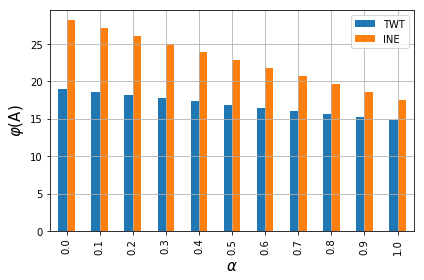

In [16]:
ax= Q_df.plot(kind='bar', grid=True);
ax.set_ylabel(r'$\varphi$(A)',fontsize=15)
ax.set_xlabel(r'$\alpha$',fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join('figs', 'quality_matrics.png'))

In [17]:
coverage_df = pd.concat([twt_coverage_df, ine_coverage_df],axis=1)

In [18]:
coverage_df.head()

,metric_value_TWT_MA,metric_value_TWT_PROV,metric_value_INE_MA,metric_value_INE_PROV
date,,,,
2020-04-01,0.138879,0.098697,0.134999,0.127690
2020-04-02,0.142513,0.100588,0.137292,0.124143
2020-04-03,0.145796,0.103861,0.152497,0.130662
2020-04-04,0.034814,0.027248,0.119120,0.117999
2020-04-05,0.078799,0.059177,0.099050,0.121126


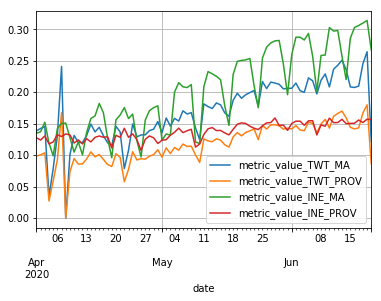

In [19]:
coverage_df.plot(grid=True)

## Distribution of trips study

In [20]:
global_twt_od = pd.read_csv(os.path.join('data', 'OD', 'global_TWT_OD.csv'), index_col=0)

In [21]:
global_ine_od = pd.read_csv(os.path.join('data', 'OD', 'global_INE_OD.csv'), index_col=0)

In [22]:
global_twt_od['norm_total']= global_twt_od['total'] / global_twt_od.loc['total','total']

In [23]:
global_ine_od['norm_total']= global_ine_od['total'] / global_ine_od.loc['total','total']

In [24]:
global_twt_od['rank']= global_twt_od['norm_total'].rank(method='first', ascending=False)

In [25]:
global_ine_od['rank']= global_ine_od['norm_total'].rank(method='first', ascending=False)

In [26]:
global_twt_od= global_twt_od.drop('total')

In [27]:
global_ine_od= global_ine_od.drop('total')

In [28]:
global_twt_od.tail()

,001A,001B,001M,001S,001V,002A,002B,002M,002S,002V,...,58TF,43AL,44AL,45AL,53MA,79MA,80MA,total,norm_total,rank
44AL,0,0,0,0,0,0,0,0,0,0,...,0,73,0,5,0,0,0,251,0.000958,180.0
45AL,0,0,0,0,0,0,0,0,0,0,...,0,4,15,0,0,0,0,31,0.000118,1472.0
53MA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,23,0,27,0.000103,1597.0
79MA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,23,0,23,552,0.002107,62.0
80MA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,36,0,87,0.000332,614.0


In [29]:
global_ine_od.tail()

,001A,001B,001M,001S,001V,002A,002B,002M,002S,002V,...,58TF,43AL,44AL,45AL,53MA,79MA,80MA,total,norm_total,rank
44AL,0,0,0,0,0,0,0,0,0,0,...,0,46805,0,55692,0,0,0,147225,0.000504,717.0
45AL,0,0,0,0,0,0,0,0,0,0,...,0,80201,104546,0,0,0,0,239148,0.000818,284.0
53MA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,109765,36900,355433,0.001216,86.0
79MA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,59748,0,28810,227763,0.000779,318.0
80MA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,16564,25721,0,130205,0.000445,825.0


In [30]:
import numpy as np

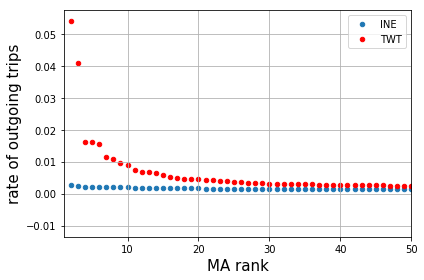

In [33]:
ax= global_ine_od['rank norm_total'.split()].plot(kind='scatter', x='rank', y='norm_total', grid=True, label='INE')#, logy=True)
global_twt_od['rank norm_total'.split()].plot(ax=ax,kind='scatter', x='rank', y='norm_total', grid=True, color='red', label='TWT')#, logx=True, color='red')
ax.set_ylabel('rate of outgoing trips',fontsize=15)
ax.set_xlabel('MA rank',fontsize=15)
ax.set_xlim(1,50)
plt.tight_layout()
plt.savefig(os.path.join('figs', 'rate_trips_ma.png'))